In [1]:
import rasterio
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os
import glob
from PIL import Image 
import imageio
from keras.utils import to_categorical
from tqdm.notebook import tqdm
import pandas as pd
import random

Using TensorFlow backend.
/home/fortanel/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/fortanel/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/fortanel/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/fortanel/.local/lib/python3.6/site-packages/tensorflo

In [2]:
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import tensorflow as tf


def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x
  
def get_unet(input_img,n_filters = 16, dropout = 0.1, batchnorm = True):
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
    
    return model

In [3]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import time

def train_model(training_model,batch_generator,x_test,y_test,epochs_train,batch_size):
    callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model_E03.h5', verbose=1, save_best_only=True, save_weights_only=True)
    ]
    training_model.summary()
    
    start_time = time.time()
    
    history = training_model.fit_generator(generator=batch_generator,
                                        steps_per_epoch= len(X_train)//batch_size,
                                        epochs=epochs_train,
                                        verbose=1,
                                        validation_data=(x_test, y_test),
                                        callbacks = callbacks)
    
    plt.figure(figsize=(8, 8))
    plt.title("Learning curve")
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.plot( np.argmin(history.history["val_loss"]), np.min(history.history["val_loss"]), marker="x", color="r", label="best model")
    plt.xlabel("Epochs")
    plt.ylabel("log_loss")
    plt.legend();
    plt.savefig("Roc_03")

  
    print("--- %s seconds ---" % (time.time() - start_time))
    return training_model

In [4]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix,roc_curve,roc_auc_score,auc
import matplotlib.pyplot as plt
def IoU(y_true,y_pred):
    inter, union = 0 , 0
    for etiqueta, prediccion in zip(y_true,y_pred):
        inter1 = y_true + y_pred
        inter1[inter1==1] = 0
    #inter[inter==2] = 1

        union1 = y_true + y_pred 
    #union[union >0] = 1
        union = union + len(union1[union1>0])
        inter = inter +  len(inter1[inter1>0])
        
    if union == 0:
        return 1
    else:
        return inter/union

def evaluate(x_test,y_test,model):
    model.load_weights("model_E03.h5")
    
    y_pred = model.predict(x_test)
    y_pred = (y_pred > 0.5).astype(np.uint8)
    
    pru_v = y_test.reshape(y_test.shape[0]*128*128*1)
    pru_p = y_pred.reshape(y_pred.shape[0]*128*128*1)

   # Print f1, precision, and recall scores
    print("Indice de Jaccard " + str(IoU(Y_test,y_pred)) )
    print("precision: "+ str(precision_score(pru_v, pru_p)))
    print("recall: " + str(recall_score(pru_v, pru_p)))
    print("f1 score: " + str(f1_score(pru_v, pru_p)))
    print("confusion matrix")
    print(confusion_matrix(pru_v, pru_p))
    
    #segundo
    
    fpr, tpr, thresholds = roc_curve(pru_v,pru_p)
    print(auc(fpr, tpr))
    plt.figure(2)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.show()

In [5]:
from skimage.io import imread
from skimage.transform import resize
import numpy as np
from keras.utils import Sequence

class Generator_mean(Sequence):

    def __init__(self, image_filenames, labels, batch_size, mean,std):
        self.image_filenames, self.labels = image_filenames, labels
        self.batch_size = batch_size
        self.mean = mean
        self.std = std

    def __len__(self):
        return int(len(self.image_filenames) / float(self.batch_size))

    def __getitem__(self, idx):
        batch_x = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        X_datos = np.empty((0,128,128,7))
        Y_etiquetas = np.empty((0,128,128,1))
        for elemento in zip(batch_x,batch_y):
            X_datos = np.append(X_datos,[np.load(elemento[0])],axis=0)
            Y_etiquetas = np.append(Y_etiquetas,[np.load(elemento[1])],axis=0) 
        
        X_datos /= self.std
        X_datos -= self.mean

        return X_datos, Y_etiquetas

In [6]:
from sklearn.model_selection import train_test_split

#mean = np.array([0.11729544, 0.10640271, 0.10532453, 0.1189142 , 0.22674469,0.20977125, 0.16156665])
std = np.array([0.06108249, 0.05862798, 0.06418259, 0.08496066, 0.1368288, 0.13501068, 0.11945581])
mean = np.array([1.9202795 , 1.8148794 , 1.64101398, 1.39963849, 1.65714158,
       1.55373817, 1.35252237])

datos = next(os.walk("/home/fortanel/Escuela/Tesis/preprocesamiento/cortadas/etiquetas/"))[2]
imagenes = ["/home/fortanel/Escuela/Tesis/preprocesamiento/cortadas/imagenes/" + imagen for imagen in datos]
imagenes = [elemento[:-5] + elemento[-4:] for elemento in imagenes]
imagenes = list(set(imagenes))
imagenes.sort()
etiquetas = [elemento.replace("imagenes","etiquetas") for elemento in imagenes]


X_train,X_t,y_train,y_t = train_test_split(imagenes,etiquetas,test_size = 0.1,random_state=42)
X_test = np.empty((0,128,128,7))
Y_test = np.empty((0,128,128,1))
for elemento in tqdm(X_t):
    nomX = elemento[:-4] + "0" + elemento[-4:]
    nomY = nomX.replace("imagenes","etiquetas")
    X_test = np.append(X_test,[np.load(nomX)],axis=0)
    Y_test = np.append(Y_test,[np.load(nomY)],axis=0) 

X_test /= std
X_test -= mean
    
X_train = [elemento[:-4]+ str(j) + elemento[-4:] for elemento in X_train for j in range(0,4)]
random.shuffle(X_train)
Y_train = [elemento.replace("imagenes", "etiquetas") for elemento in X_train]
batch_size = 64
my_training_batch_generator = Generator_mean(X_train, Y_train, batch_size,mean,std)

In [7]:
input_img = Input((128, 128, 7), name='img')
u_net = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 128, 128, 7)  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 16) 1024        img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 128, 128, 16) 64          conv2d_2[0][0]                   
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 128, 128, 16) 0           batch_normalization_2[0][0]      
____________________________________________________________________________________________


Epoch 1/15
63/63 [==============================] - 374s 6s/step - loss: 0.2328 - accuracy: 0.9274 - val_loss: 0.2555 - val_accuracy: 0.9234

Epoch 00001: val_loss improved from inf to 0.25554, saving model to model_E03.h5
Epoch 2/15
63/63 [==============================] - 429s 7s/step - loss: 0.1305 - accuracy: 0.9607 - val_loss: 0.1722 - val_accuracy: 0.9335

Epoch 00002: val_loss improved from 0.25554 to 0.17222, saving model to model_E03.h5
Epoch 3/15
63/63 [==============================] - 375s 6s/step - loss: 0.1069 - accuracy: 0.9649 - val_loss: 0.1213 - val_accuracy: 0.9547

Epoch 00003: val_loss improved from 0.17222 to 0.12127, saving model to model_E03.h5
Epoch 4/15
63/63 [==============================] - 373s 6s/step - loss: 0.0915 - accuracy: 0.9688 - val_loss: 0.1106 - val_accuracy: 0.9605

Epoch 00004: val_loss improved from 0.12127 to 0.11062, saving model to model_E03.h5
Epoch 5/15
63/63 [==============================] - 379s 6s/step - loss: 0.0838 - accuracy: 0.9

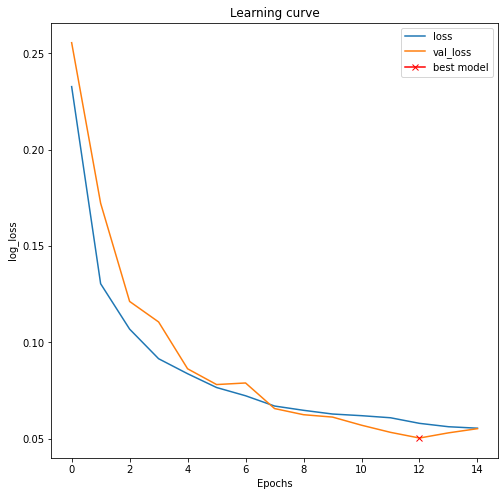

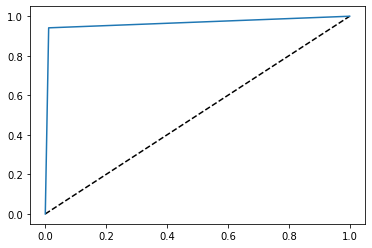

In [8]:
history = train_model(u_net,my_training_batch_generator,X_test,Y_test,epochs_train = 15,batch_size = 64)
evaluate(X_test,Y_test,u_net)

/home/fortanel/Escuela/Tesis/Imagenes/CUADROS-8/LC08_033042_2018abr17_stack.tif
(121, 128, 128, 7)
121/121 [==============================] - 2s 20ms/step


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


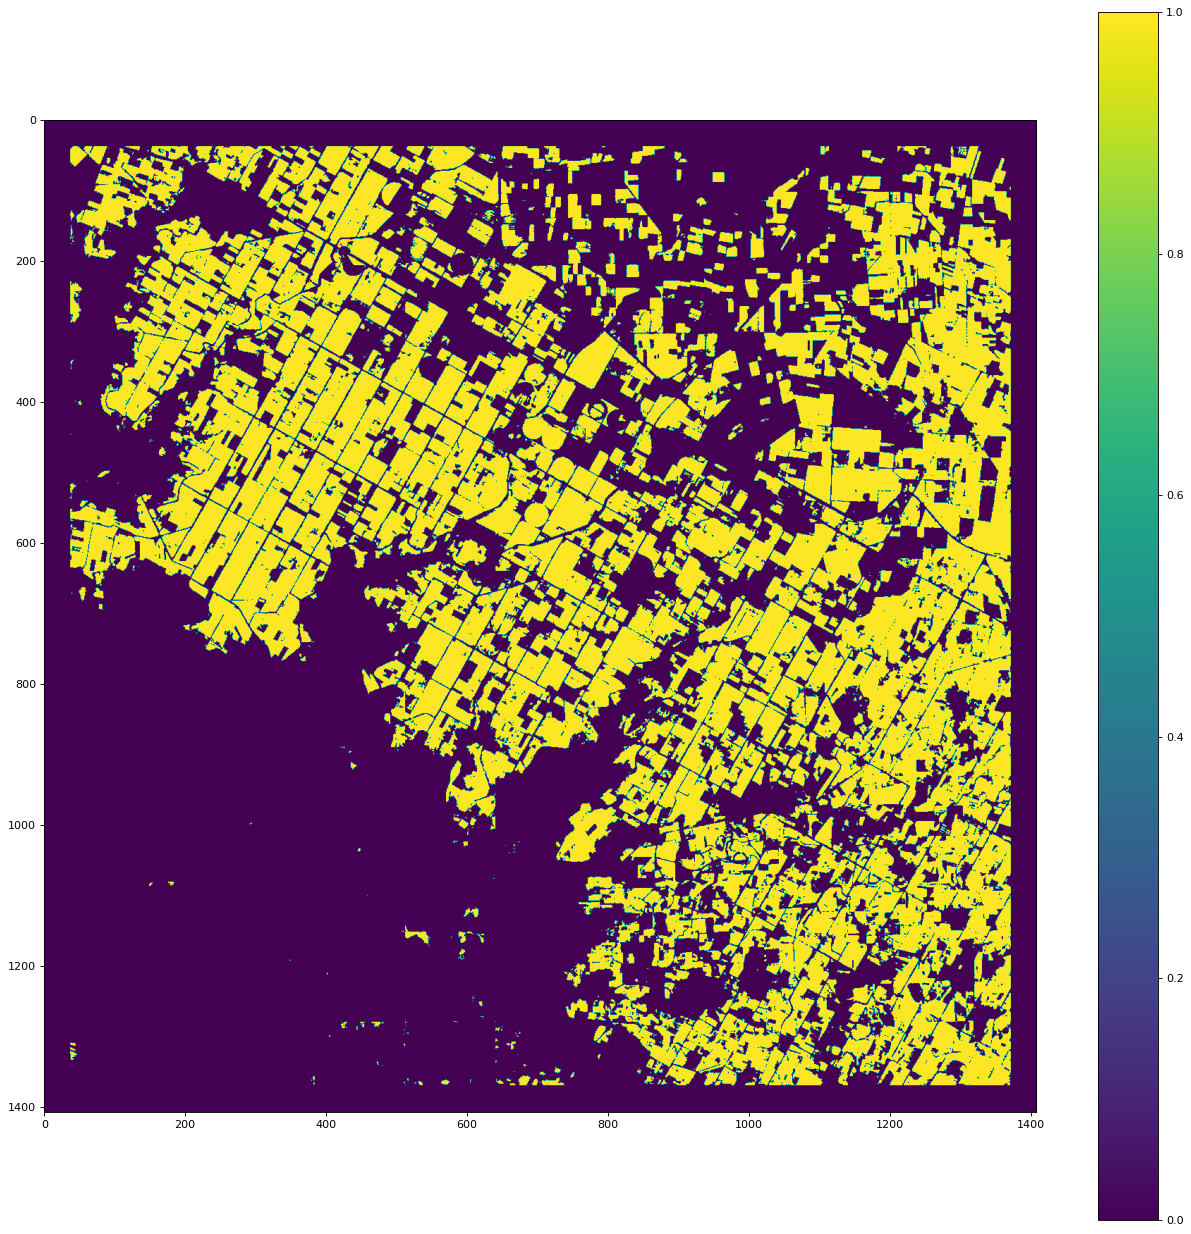

In [20]:
import os
import glob
#imagenes = next(os.walk("/home/fortanel/Escuela/Tesis/Imagenes/wetransfer-c12f06/ImagenesSat/AutlanJalisco2019/"))[2]
#imagenes
data_dir = "/home/fortanel/Escuela/Tesis/Imagenes/"
eti_dir =  "/home/fortanel/Escuela/Tesis/etiquetas/"

files = glob.glob("/home/fortanel/Escuela/Tesis/Imagenes/" + '/**/*.tif', recursive=True)
nombres = [os.path.basename(elemento) for elemento in files]
nombres = [elemento.replace(".tif","") for elemento in nombres]
terminadas = glob.glob("/home/fortanel/Escuela/Tesis/etiquetas/" + '*.png', recursive=True)
terminadas = [os.path.basename(elemento) for elemento in terminadas]
terminadas = [ elemento.replace("_mascara_terminada.png","") for elemento in terminadas]
#ind =nombres.index("LC08_033042_2018abr1")
#ind = 12
ind = 161
raster = rasterio.open(files[ind])
print(files[ind])

X = raster.read(1)
hor = 128 - X.shape[0] %128 
ver = 128 - X.shape[1] %128
X = np.pad(X,((int(hor/2),hor - int(hor/2)),(int(ver/2),ver - int(ver/2))))
X = np.where(np.isnan(X), 0,X)
X[X<0] = 0
imagen = np.empty((0,raster.read(1).shape[0]+ ver,raster.read(1).shape[1]+hor))
for i in range(2,8):
    datos = raster.read(i)
    datos = np.pad(datos,((int(hor/2),hor - int(hor/2)),(int(ver/2),ver - int(ver/2))))
    datos = np.where(np.isnan(datos), 0,datos)
    datos[datos<0] = 0
    X = np.dstack((X,datos))

#imagen = imagen.reshape(imagen.shape[1],imagen.shape[2],7)
imagen = X
cortadas = np.empty((0,128,128,7))
alt = int(imagen.shape[0]/128)
anc = int(imagen.shape[1]/128)
for i in range(0,alt):
        for j in range(0,anc):
            cuadro_X = imagen[i*128:(i+1)*128,j*128:(j+1)*128]
            cortadas = np.append(cortadas,[cuadro_X],axis=0)
            
print(cortadas.shape)
cortadas /= std
cortadas -= mean
resultado = u_net.predict(cortadas, verbose=1)
resultado = (resultado > 0.5).astype(np.uint8)

mascara = np.empty((128*alt,128*anc))
for i in range(0,alt):
    for j in range(0,anc):
        mascara[128*i:128*(i+1),128*j:128*(j+1)] = resultado[i*alt+j].reshape(128,128)
mascara.shape

figure(num=None, figsize=(20, 20), dpi=80, facecolor='w', edgecolor='k')
#Muestra la imagen

plt.imshow(mascara)
plt.colorbar()
imageio.imwrite("parcelas"+'.png', mascara,compression=0)